In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import safe as sf
import datamol as dm
from safe.sample import logger
# clean logger a bit
logger.configure(handlers=[{"sink": sys.stdout, "level": "INFO"}])


[1]

Load the default pretrained Safe model.

We will use this unique model for all the downstream molecular design tasks.


In [3]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model


/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)


Let's start with the below molecule.


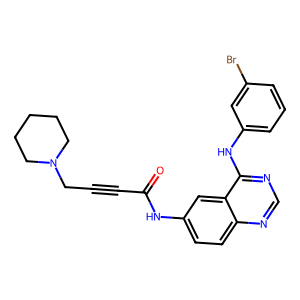

In [4]:
candidate_smiles = "O=C(C#CCN1CCCCC1)Nc1ccc2ncnc(Nc3cccc(Br)c3)c2c1"
candidate_mol = dm.to_mol(candidate_smiles)

dm.to_image(candidate_mol)


## De novo generation

Generation of novel molecules without any constraints.


In [5]:
generated_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=12)

generated_smiles[:5]


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/emmanuel.noutahi/miniconda3/envs/safe/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


2024-09-12 14:35:07.152 | INFO     | safe.sample:de_novo_generation:760 - After sanitization, 12 / 12 (100.00 %) generated molecules are valid !


['CC(C)(C)OC(=O)N1CC[C@@]2(C(=O)N3C[C@H]4COC[C@@H](C3)[C@H]4NC(=O)C3(C)COC3)C[C@@H]2C1',
 'C[C@@H](N=C(O)Cc1ccc([N+](=O)[O-])cc1)c1ccccn1',
 'N#Cc1ccc(N2C[C@H]3CC[C@@H](C2)N3C(=O)CCc2cn[nH]n2)nc1',
 'CC(C)c1occc1C(=O)N1CC[C@@H](CNc2cnc(C#N)cn2)C1',
 'C=C(Cl)CN(Cc1ccco1)C(=O)NCc1ccccc1CNC(=O)OC(C)(C)C']

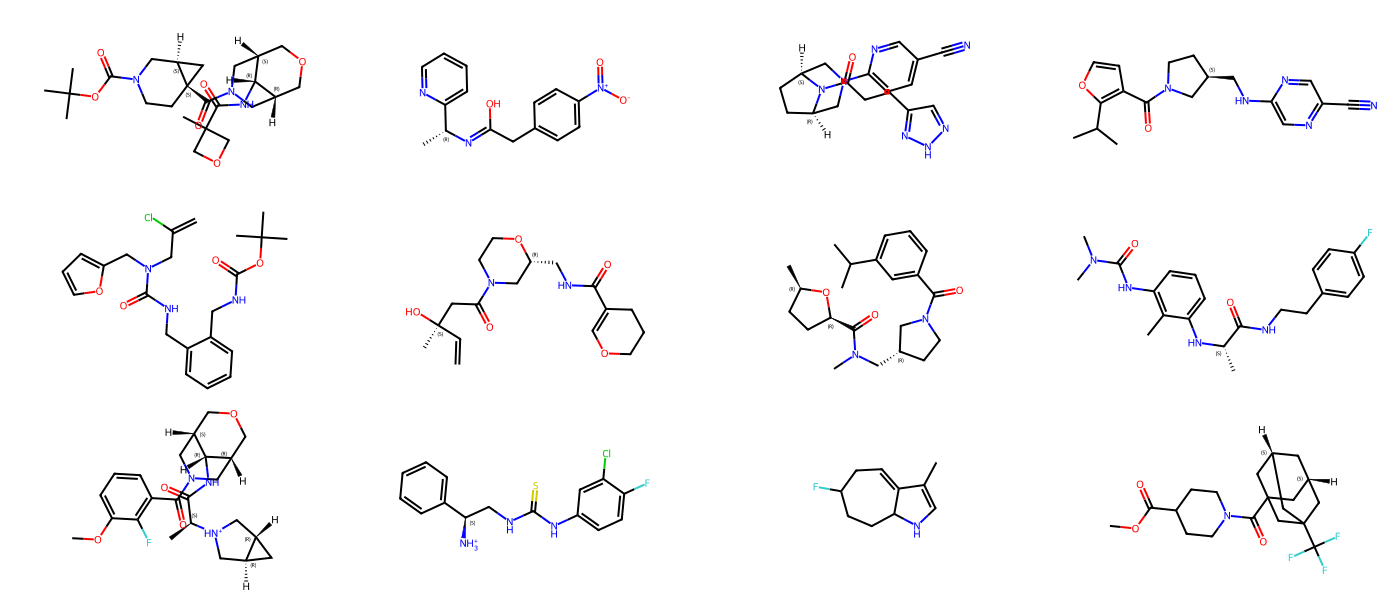

In [6]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Scaffold Decoration

For scaffold decoration, we wish to generate new molecules that would contain a given scaffold as core. Usually, the attachment point on the scaffold should dictate where the new vectors will be added.


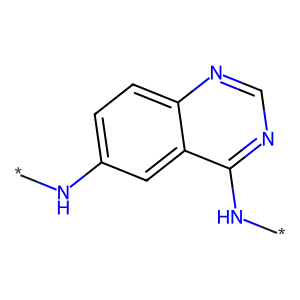

In [7]:
scaffold = "[*]N-c1ccc2ncnc(-N[*])c2c1"

dm.to_image(scaffold)


In [8]:
generated_smiles = designer.scaffold_decoration(
    scaffold=scaffold,
    n_samples_per_trial=12,
    n_trials=2,
    sanitize=True,
    do_not_fragment_further=True,
)

generated_mols = [dm.to_mol(x) for x in generated_smiles]


  0%|          | 0/2 [00:00<?, ?it/s]

2024-09-12 14:35:21.081 | INFO     | safe.sample:scaffold_decoration:635 - After sanitization, 23 / 24 (95.83 %)  generated molecules are valid !


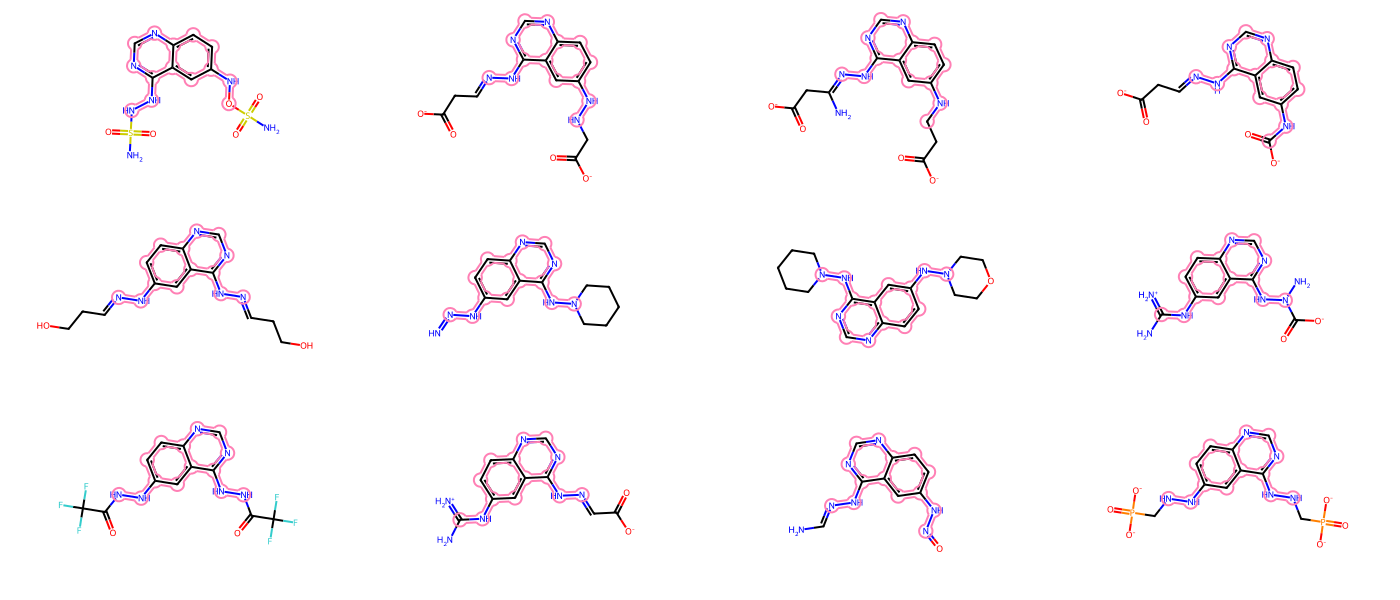

In [9]:
dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(scaffold), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)


## Pattern decoration

For pattern decoration, we wish to generate new molecules that would contain a given molecular pattern expressed as a SMARTS. [SMARTS](https://daylight.com/dayhtml/doc/theory/theory.smarts.html) are different from scaffolds as they allow allows "rules" for matching several atoms and bonds simultaneously. In SAFE, the pattern decoration only supports a subset of the SMARTS specification. We recommend filtering generated compounds after to preserve your specifc input patterns. Alternatively, you can use the `sanitize` input.

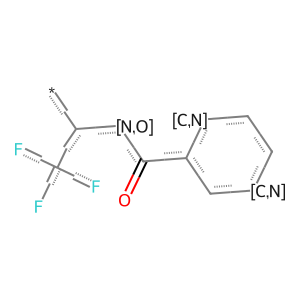

In [10]:
patterns = "FC(F)(F)C(*)[N,#8]C(=O)c1[c,n]cc[c,n]c1"
dm.to_image(dm.from_smarts(patterns))

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-12 14:35:42.532 | INFO     | safe.sample:pattern_decoration:719 - After sanitization, 27 / 50 (54.00%) generated molecules are valid!


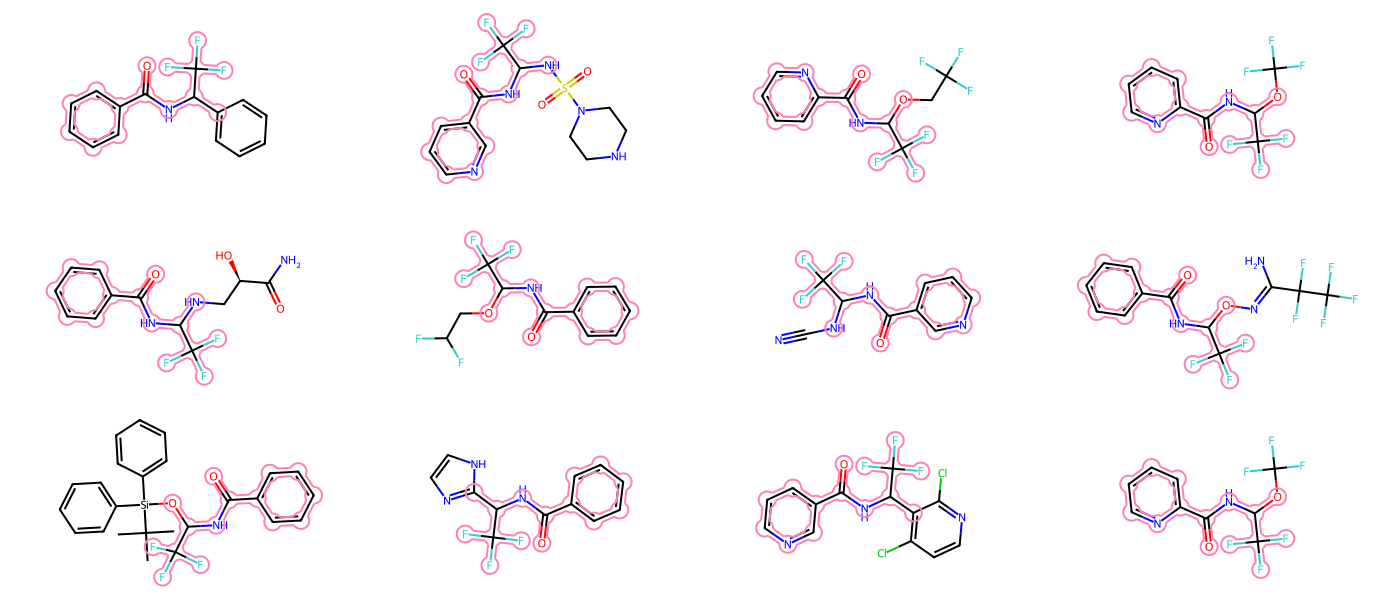

In [11]:
generated_smiles = designer.pattern_decoration(patterns,
    n_samples_per_trial=50,
    n_trials=1,
    sanitize=True,
    n_scaff_samples=10,
    n_scaff_random=5,
    do_not_fragment_further=True,
)
    
generated_mols = [dm.to_mol(x) for x in generated_smiles]
dm.viz.lasso_highlight_image(generated_mols[:12], dm.from_smarts(patterns), mol_size=(350, 200), color_list=["#ff80b5"], scale_padding=0.1)


## Super structure generation

In super structure generation, we just want to generate superstructure of a molecular subgraph


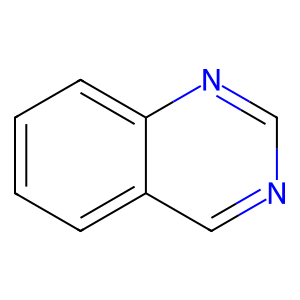

In [12]:
superstructure = "c1ccc2ncncc2c1"

dm.to_image(superstructure)


In [13]:
generated_smiles = designer.super_structure(
    core=superstructure,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    attachment_point_depth=3,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-12 14:35:44.980 | INFO     | safe.sample:super_structure:589 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['NC=Nc1nc(C(N)=O)c2cc([N+](=O)[O-])ccc2n1',
 'N#CCCNc1ccc2nc(C(N)=O)nc(C(N)=O)c2c1',
 'FC(F)(F)c1ccc2nc(C(F)(F)F)nc(C(F)(F)F)c2c1',
 'FC(F)COCCNc1ccc2nc(C(F)(F)F)nc(C(F)(F)F)c2c1',
 'NC=Nc1nc(/C=C/N)c2cc(S(N)(=O)=O)ccc2n1',
 'O=[N+]([O-])c1ccc2nc(C(F)F)nc(N=S)c2c1',
 'NC(=S)c1ccc2ncnc(N=CCC(F)(F)F)c2c1',
 'N#CNc1nc(C(F)(F)C(F)(F)F)c2cc(C(F)(F)F)ccc2n1',
 'OCc1nc(NCCCC(F)(F)F)nc2ccc(C(F)(F)F)cc12',
 'O[C@H](CCNc1nc(C(F)(F)F)nc2ccc(C(F)(F)F)cc12)C(F)(F)F',
 'O=C([O-])C(F)(F)C(F)(F)C(=O)Nc1nc(CO)c2cc(C(F)(F)F)ccc2n1',
 'N#C[C@@H](Nc1nc(C(F)(F)F)c2cc(C(=O)[O-])ccc2n1)C(N)=O']

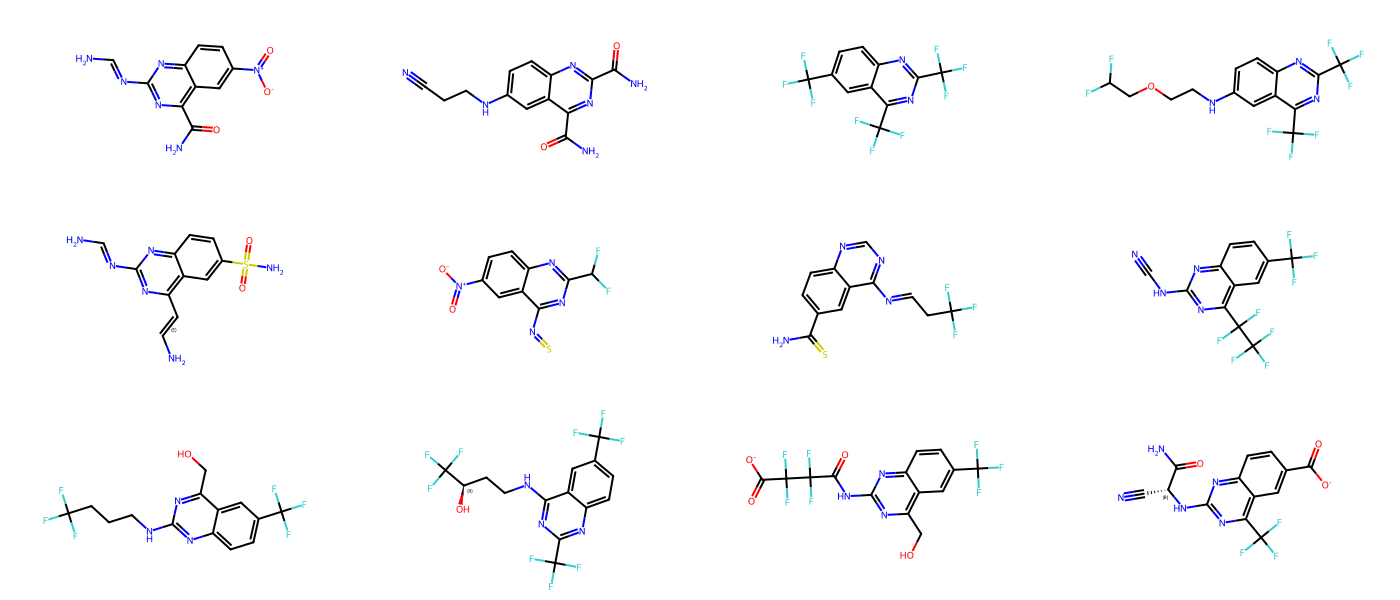

In [14]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Motif Extension

In motif extension, we are interested in generating a molecule containing a given motif as starting point.


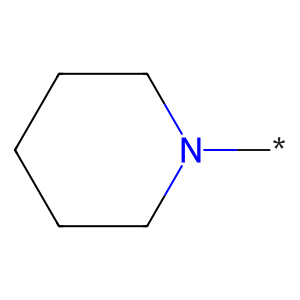

In [15]:
motif = "[*]-N1CCCCC1"

dm.to_image(motif)


In [16]:
# let's make some long sequence
generated_smiles = designer.motif_extension(
    motif=motif,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    min_length=25,
    max_length=80,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-12 14:35:47.217 | INFO     | safe.sample:scaffold_decoration:635 - After sanitization, 11 / 12 (91.67 %)  generated molecules are valid !


['O=S(=O)([O-])CCCCCCCCCN1CCCCC1.[Na+]',
 'O=C(c1n[nH]nc1N1CCCCC1)N1CCCCC1',
 'C1CCN(CC2CCCNCC2)CC1',
 'C1CCN([C@H]2CNCCO2)CC1.Cl.Cl.Cl',
 'C1CCN(C2CCC2)CC1.N=c1ncc(C(F)(F)F)n[nH]1',
 'Cl.N=C(O)C(N)CN1CCCCC1',
 'O=C(NCCSC(F)(F)F)[C@@H](CCC(F)(F)F)N1CCCCC1',
 'C1CCN(CCNC2CCCNCC2)CC1',
 'O=C(NCCN(CC(=O)N1CCCCC1)CC(F)F)C(F)F',
 'CC(CF)(CF)NS(=O)(=O)CCCS(=O)(=O)N1CCCCC1',
 'O=C1CCCCN1CCN1CCCCC1']

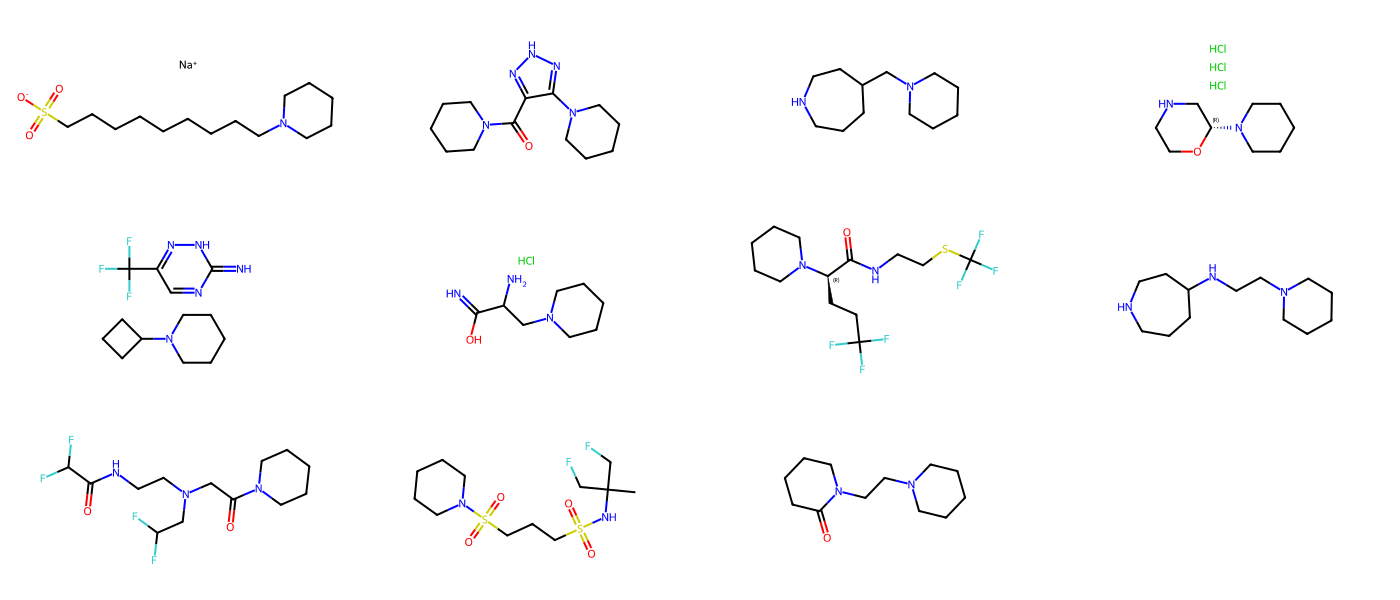

In [17]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Scaffold Morphing

In scaffold morphing, we wish to replace a scaffold by another one in a molecule. The process requires as input that the user provides either the side chains or the input molecules and the core


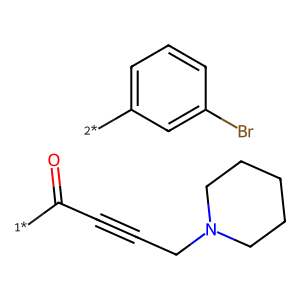

In [18]:
side_chains = "[1*]C(=O)C#CCN1CCCCC1.[2*]c1cccc(Br)c1"

dm.to_image(side_chains)


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-12 14:35:52.033 | INFO     | safe.sample:_fragment_linking:490 - After sanitization, 8 / 12 (66.67 %)  generated molecules are valid !


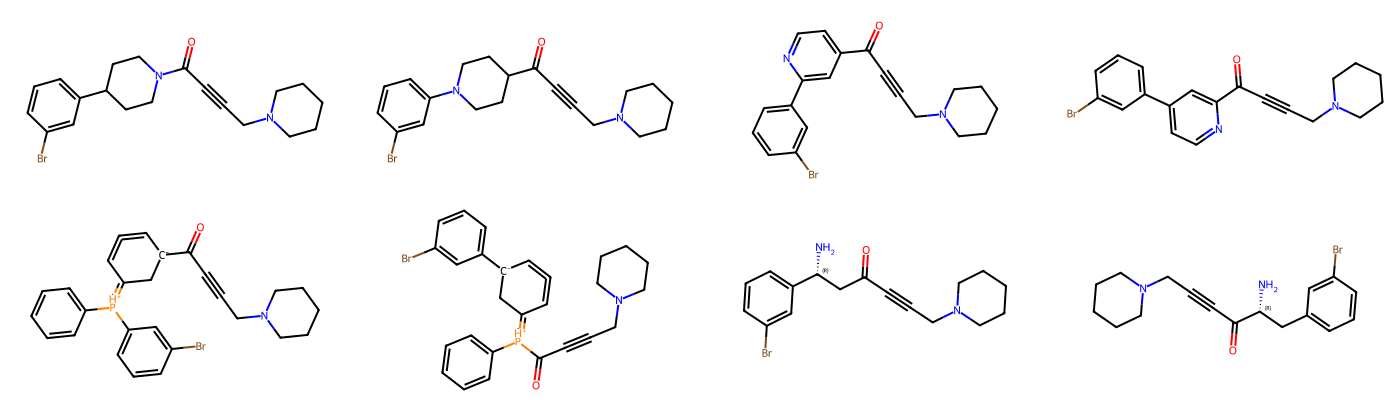

In [19]:
generated_smiles = designer.scaffold_morphing(
    side_chains=side_chains,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

dm.to_image(generated_smiles[:12], mol_size=(350, 200))


## Linker generation

Linker generation is mostly the same thing as scaffold morphing ...


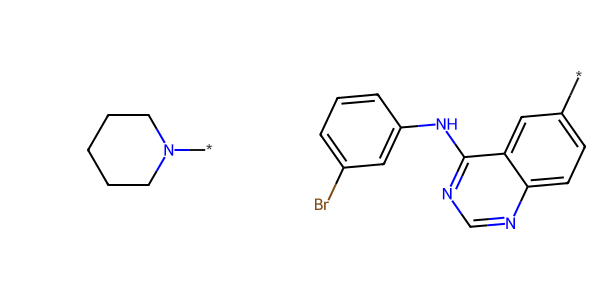

In [20]:
linker_generation = ["[*]-N1CCCCC1", "Brc1cccc(Nc2ncnc3ccc(-[*])cc23)c1"]

dm.to_image(linker_generation)


In [21]:
generated_smiles = designer.linker_generation(
    *linker_generation,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

generated_smiles


  0%|          | 0/1 [00:00<?, ?it/s]

2024-09-12 14:35:56.575 | INFO     | safe.sample:_fragment_linking:490 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['Brc1cccc(Nc2ncnc3ccc(-c4ccc5nc6c(-n7cccn7)ccc(-c7ccc(OCCCN8CCCCC8)cc7)c6nc5c4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(CCCOc4ccc(-c5ccc(-n6cccn6)c6nc7ccc(N8CCCCC8)cc7nc56)cc4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4ccc5c(c4)c4c6ccccc6n(-c6cccc(N7CCCCC7)c6)c4n5-c4ccccc4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4cccc(-n5c6ccccc6c6c7cc(N8CCCCC8)ccc7n(-c7ccccc7)c65)c4)cc23)c1',
 'O=C(CN1CC=C(CCCN=c2[nH]n(C(=O)CN3CCCCC3)c3ncccc23)CC1)n1nc(-c2ccc3ncnc(Nc4cccc(Br)c4)c3c2)c2cccnc21',
 'O=C(CN1CC=C(CCCN=c2[nH]n(C(=O)Cc3ccc4ncnc(Nc5cccc(Br)c5)c4c3)c3ncccc23)CC1)n1nc(N2CCCCC2)c2cccnc21',
 'Brc1cccc(Nc2ncnc3ccc(Cc4ccc(-c5ccc(N6CCCCC6)cc5)cc4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4ccc(-c5ccc(CN6CCCCC6)cc5)cc4)cc23)c1',
 'O=C(NC1NNC2C1=CC=CC2CN1CCCCC1)c1ccc(-c2ccc3ncnc(Nc4cccc(Br)c4)c3c2)s1',
 'O=C(NC1NNC2C1=CC=CC2Cc1ccc2ncnc(Nc3cccc(Br)c3)c2c1)c1ccc(N2CCCCC2)s1',
 'Brc1cccc(Nc2ncnc3ccc([Si](c4ccccc4)(c4ccccc4)c4cccc(N5CCCCC5)n4)cc23)c1',
 'Brc1cccc(Nc2ncnc3ccc(-c4cccc([Si](c5ccccc5)(c5ccccc5)N5CCCCC5)n4)cc23)c1']

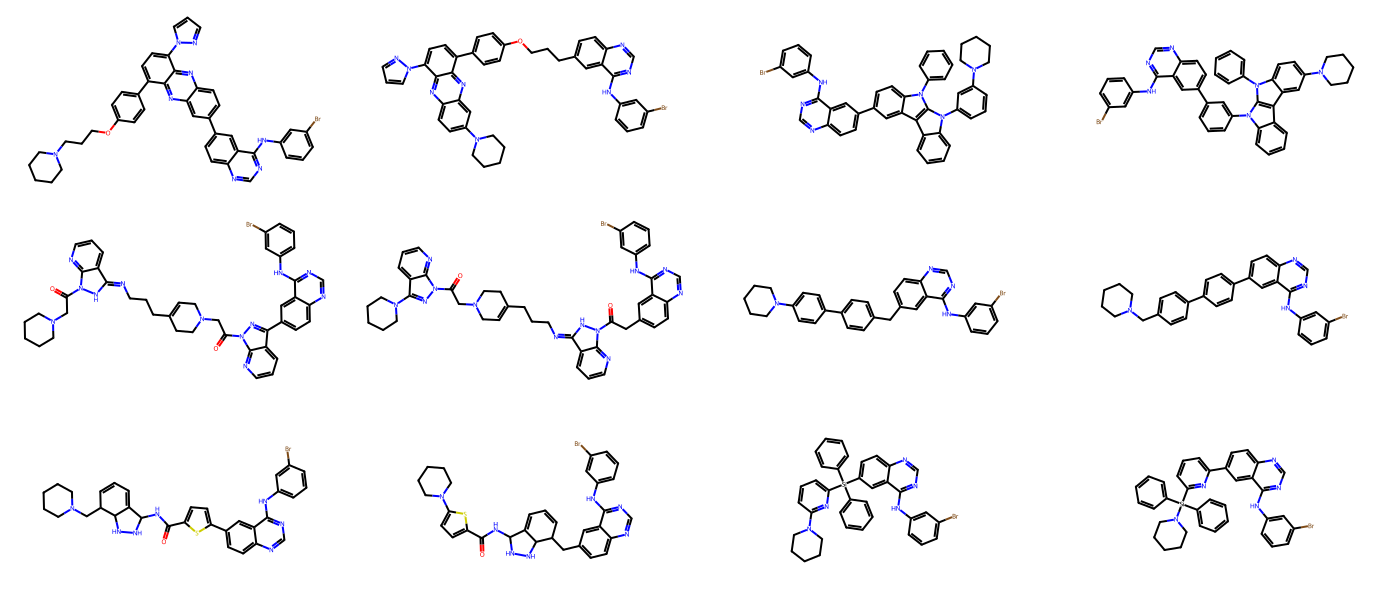

In [22]:
dm.to_image(generated_smiles[:12], mol_size=(350, 200))


---

The End !